In [21]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from numpy import array
from datetime import datetime
import seaborn as sns

In [22]:
sns.set_style("darkgrid")
cm = 1/2.54 
colors = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

### Replace missing values with Zero and Group by month

In [23]:
df = pd.read_csv('consumos_cst.csv', parse_dates=['date'])
df = df.set_index('date')
df = df.groupby('cst').resample('M').sum()

### Create batches of training data (12 months)

In [24]:
def split_sequence(sequence, n_steps_in, n_steps_out, slide):
    X, y = list(), list()
    for i in range(0, len(sequence), slide):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

### Define and fit LSTM model 

In [25]:
def fit(X, y, n_steps_in, n_steps_out):
    callback = EarlyStopping(monitor='loss', patience=50)
    model = Sequential()
    model.add(LSTM(units=70, activation='relu', input_shape=(n_steps_in, 1)))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=500, callbacks=[callback])
    return model 

In [26]:
def train_predict(dataset, test, actual):
    n_steps_in, n_steps_out, slide = 6, 2, 1
    X, y = split_sequence(dataset, n_steps_in, n_steps_out, slide)
    
    # flatten input and output
    n_input = X.shape[1] * X.shape[2]
    X = X.reshape((X.shape[0], n_input))
    n_output = y.shape[1] * y.shape[2]
    y = y.reshape((y.shape[0], n_output))
    
    #print(X[0], y[0], len(X[0]), len(y[0]))
    model = fit(X, y, n_input, n_output)      
    
    mae, rmse, smape = list(), list(), list()
    for i in range(0, len(test)-n_steps_in, n_steps_out):
        x_input = array(test[i:n_steps_in+i])
        x_input = x_input.reshape((1, n_input, 1))
        pred = model.predict(x_input).reshape(-1, 1)
        pred = scaler.inverse_transform(pred)
        mae_aux, rmse_aux, smape_aux = measure_error(actual, pred, n_steps_in, n_steps_out, i)
        mae.append(mae_aux), rmse.append(rmse_aux), smape.append(smape_aux)
        #print(x_input, current_pred)
    
    return mae, rmse, smape

In [27]:
def sMAPE(actual, predicted):
    if not all([isinstance(actual, np.ndarray), 
                isinstance(predicted, np.ndarray)]):
        actual, predicted = np.array(actual),
        np.array(predicted)
    return round(np.mean(np.abs(predicted - actual) / ((np.abs(predicted) + np.abs(actual))/2))*100, 2)

In [28]:
def measure_error(actual, pred, step_in, step_out, index):
    #print(actual[index+step_in:index+step_in+step_out],pred,index+step_in,index+step_in+step_out)
    mae = mean_absolute_error(actual[index+step_in:index+step_in+step_out], pred)
    rmse = np.sqrt(mean_squared_error(actual[index+step_in:index+step_in+step_out], pred))
    smape = sMAPE(actual[index+step_in:index+step_in+step_out], pred)
    return mae, rmse, smape

### Normalize Data Set and Split Train and Test

In [29]:
df = df.pivot_table('nr', 'date', 'cst')
df = df.fillna(0)

In [30]:
dataset = df[['Coimbra']].values
dataset = df[['Coimbra']].astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
mae1, rmse1, smape1 = train_predict(dataset[:216], dataset[216:], df[['Coimbra']][216:].values)

Epoch 1/500
7/7 [==============================] - 2s 7ms/step - loss: 0.3508
Epoch 2/500
7/7 [==============================] - 0s 7ms/step - loss: 0.2839
Epoch 3/500
7/7 [==============================] - 0s 6ms/step - loss: 0.2171
Epoch 4/500
7/7 [==============================] - 0s 5ms/step - loss: 0.1436
Epoch 5/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0723
Epoch 6/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0305
Epoch 7/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0202
Epoch 8/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0165
Epoch 9/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0158
Epoch 10/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0129
Epoch 11/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0131
Epoch 12/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0122
Epoch 13/500
7/7 [==============================] - 0s 6ms/st

7/7 [==============================] - 0s 5ms/step - loss: 0.0096
Epoch 105/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0098
Epoch 106/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0100
Epoch 107/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0100
Epoch 108/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0097
Epoch 109/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0098
Epoch 110/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0098
Epoch 111/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0097
Epoch 112/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0096
Epoch 113/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0100
Epoch 114/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0097
Epoch 115/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0097
Epoch 116/500
7/7 [==============================] - 0

7/7 [==============================] - 0s 7ms/step - loss: 0.0095
Epoch 207/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0100
Epoch 208/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0099
Epoch 209/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0097
Epoch 210/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0096
Epoch 211/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0096
Epoch 212/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0097
Epoch 213/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0097
Epoch 214/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0095
Epoch 215/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0096
Epoch 216/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0096
Epoch 217/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0097
Epoch 218/500
7/7 [==============================] - 0

7/7 [==============================] - 0s 6ms/step - loss: 0.0094
Epoch 309/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0095
Epoch 310/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0095
Epoch 311/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0094
Epoch 312/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0096
Epoch 313/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0095
Epoch 314/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0099
Epoch 315/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0095
Epoch 316/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0093
Epoch 317/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0094
Epoch 318/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0094
Epoch 319/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0094
Epoch 320/500
7/7 [==============================] - 0

7/7 [==============================] - 0s 6ms/step - loss: 0.0094
Epoch 411/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0096
Epoch 412/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0094
Epoch 413/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0094
Epoch 414/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0095
Epoch 415/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0095
Epoch 416/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0093
Epoch 417/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0095
Epoch 418/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0092
Epoch 419/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0093
Epoch 420/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0092
Epoch 421/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0092
Epoch 422/500
7/7 [==============================] - 0

In [31]:
dataset = df[['Lisboa']].values
dataset = df[['Lisboa']].astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
mae2, rmse2, smape2 = train_predict(dataset[:216], dataset[216:], df[['Lisboa']][216:].values)

Epoch 1/500
7/7 [==============================] - 1s 6ms/step - loss: 0.3939
Epoch 2/500
7/7 [==============================] - 0s 6ms/step - loss: 0.3429
Epoch 3/500
7/7 [==============================] - 0s 6ms/step - loss: 0.2915
Epoch 4/500
7/7 [==============================] - 0s 6ms/step - loss: 0.2350
Epoch 5/500
7/7 [==============================] - 0s 7ms/step - loss: 0.1679
Epoch 6/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0912
Epoch 7/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0275
Epoch 8/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0221
Epoch 9/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0170
Epoch 10/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0160
Epoch 11/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0148
Epoch 12/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0141
Epoch 13/500
7/7 [==============================] - 0s 5ms/st

7/7 [==============================] - 0s 6ms/step - loss: 0.0124
Epoch 105/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0124
Epoch 106/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0124
Epoch 107/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0124
Epoch 108/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0124
Epoch 109/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0125
Epoch 110/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0127
Epoch 111/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0123
Epoch 112/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0125
Epoch 113/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0125
Epoch 114/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0123
Epoch 115/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0123
Epoch 116/500
7/7 [==============================] - 0

7/7 [==============================] - 0s 5ms/step - loss: 0.0121
Epoch 207/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0117
Epoch 208/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0116
Epoch 209/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0116
Epoch 210/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0120
Epoch 211/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0123
Epoch 212/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0123
Epoch 213/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0119
Epoch 214/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0121
Epoch 215/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0123
Epoch 216/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0118
Epoch 217/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0119
Epoch 218/500
7/7 [==============================] - 0

7/7 [==============================] - 0s 7ms/step - loss: 0.0107
Epoch 309/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0110
Epoch 310/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0110
Epoch 311/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0112
Epoch 312/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0115
Epoch 313/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0108
Epoch 314/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0109
Epoch 315/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0109
Epoch 316/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0108
Epoch 317/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0108
Epoch 318/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0110
Epoch 319/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0108
Epoch 320/500
7/7 [==============================] - 0

7/7 [==============================] - 0s 5ms/step - loss: 0.0104
Epoch 411/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0103
Epoch 412/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0103
Epoch 413/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0106
Epoch 414/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0105
Epoch 415/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0103
Epoch 416/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0106
Epoch 417/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0118
Epoch 418/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0111
Epoch 419/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0106
Epoch 420/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0105
Epoch 421/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0105
Epoch 422/500
7/7 [==============================] - 0

In [32]:
dataset = df[['Porto']].values
dataset = df[['Porto']].astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
mae3, rmse3, smape3 = train_predict(dataset[:216], dataset[216:], df[['Porto']][216:].values)

Epoch 1/500
7/7 [==============================] - 1s 5ms/step - loss: 0.5124
Epoch 2/500
7/7 [==============================] - 0s 7ms/step - loss: 0.4317
Epoch 3/500
7/7 [==============================] - 0s 6ms/step - loss: 0.3440
Epoch 4/500
7/7 [==============================] - 0s 6ms/step - loss: 0.2440
Epoch 5/500
7/7 [==============================] - 0s 7ms/step - loss: 0.1298
Epoch 6/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0290
Epoch 7/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0253
Epoch 8/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0121
Epoch 9/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0116
Epoch 10/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0096
Epoch 11/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0080
Epoch 12/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0080
Epoch 13/500
7/7 [==============================] - 0s 7ms/st

7/7 [==============================] - 0s 6ms/step - loss: 0.0064
Epoch 105/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0064
Epoch 106/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0066
Epoch 107/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0065
Epoch 108/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0066
Epoch 109/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0066
Epoch 110/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0067
Epoch 111/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0064
Epoch 112/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0066
Epoch 113/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0065
Epoch 114/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0064
Epoch 115/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0065
Epoch 116/500
7/7 [==============================] - 0

7/7 [==============================] - 0s 6ms/step - loss: 0.0063
Epoch 207/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0061
Epoch 208/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0062
Epoch 209/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0062
Epoch 210/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0066
Epoch 211/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0062
Epoch 212/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0062
Epoch 213/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0061
Epoch 214/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0061
Epoch 215/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0061
Epoch 216/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0061
Epoch 217/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0062
Epoch 218/500
7/7 [==============================] - 0

7/7 [==============================] - 0s 6ms/step - loss: 0.0061
Epoch 309/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0060
Epoch 310/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0060
Epoch 311/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0060
Epoch 312/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0060
Epoch 313/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0060
Epoch 314/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0060
Epoch 315/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0063
Epoch 316/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0064
Epoch 317/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0063
Epoch 318/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0061
Epoch 319/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0060
Epoch 320/500
7/7 [==============================] - 0

7/7 [==============================] - 0s 7ms/step - loss: 0.0060
Epoch 411/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0058
Epoch 412/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0060
Epoch 413/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0059
Epoch 414/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0060
Epoch 415/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0060
Epoch 416/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0061
Epoch 417/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0063
Epoch 418/500
7/7 [==============================] - 0s 13ms/step - loss: 0.0061
Epoch 419/500
7/7 [==============================] - 0s 10ms/step - loss: 0.0060
Epoch 420/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0059
Epoch 421/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0060
Epoch 422/500
7/7 [==============================] -

In [33]:
mae = np.average([mae1, mae2, mae3], axis=0)
rmse = np.average([rmse1, rmse2, rmse3], axis=0)
smape = np.average([smape1, smape2, smape3], axis=0)

In [34]:
len(smape)

15

### Calculate Error

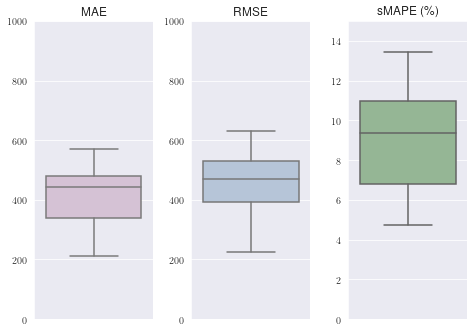

In [19]:
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(17*cm,12*cm))
sns.boxplot(ax=axes[0], y=mae, color='thistle', showfliers=False)
axes[0].set_title('MAE')
axes[0].set(ylim=(0, 1000))
sns.boxplot(ax=axes[1], y=rmse, color='lightsteelblue', showfliers=False)
axes[1].set_title('RMSE')
axes[1].set(ylim=(0, 1000))
sns.boxplot(ax=axes[2], y=smape, color='darkseagreen', showfliers=False)
axes[2].set_title('sMAPE (\%)')
axes[2].set(ylim=(0, 15))
plt.tight_layout()
plt.savefig('figures/demand_lstm_monthly_cst_single_boxplot.pdf')

In [20]:
demand_lstm_month_cst_single = [mae,rmse,smape]
%store demand_lstm_month_cst_single

Stored 'demand_lstm_month_cst_single' (list)
